In [0]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/Kaggle2"
# /content/gdrive/My Drive/Kaggle is the path where kaggle.json is present in the Google Drive

In [2]:
%cd /content/drive/My Drive/Kaggle2

/content/drive/My Drive/Kaggle2


In [3]:
pwd

'/content/drive/My Drive/Kaggle2'

In [4]:
!ls '/content/drive/My Drive/Kaggle2'

kaggle.json


In [5]:
!kaggle datasets download -d hortonhearsafoo/camvid-tiramisu

 97% 345M/357M [00:15<00:00, 34.1MB/s]
100% 357M/357M [00:15<00:00, 24.4MB/s]


In [6]:
!ls '/content/drive/My Drive/Kaggle2'

camvid-tiramisu.zip  kaggle.json


In [7]:
!unzip '/content/drive/My Drive/Kaggle2/camvid-tiramisu.zip'

Archive:  /content/drive/My Drive/Kaggle2/camvid-tiramisu.zip
  inflating: .gitattributes          
  inflating: .gitignore              
  inflating: CamVid/test.txt         
  inflating: CamVid/test/0001TP_008550.png  
  inflating: CamVid/test/0001TP_008580.png  
  inflating: CamVid/test/0001TP_008610.png  
  inflating: CamVid/test/0001TP_008640.png  
  inflating: CamVid/test/0001TP_008670.png  
  inflating: CamVid/test/0001TP_008700.png  
  inflating: CamVid/test/0001TP_008730.png  
  inflating: CamVid/test/0001TP_008760.png  
  inflating: CamVid/test/0001TP_008790.png  
  inflating: CamVid/test/0001TP_008820.png  
  inflating: CamVid/test/0001TP_008850.png  
  inflating: CamVid/test/0001TP_008880.png  
  inflating: CamVid/test/0001TP_008910.png  
  inflating: CamVid/test/0001TP_008940.png  
  inflating: CamVid/test/0001TP_008970.png  
  inflating: CamVid/test/0001TP_009000.png  
  inflating: CamVid/test/0001TP_009030.png  
  inflating: CamVid/test/0001TP_009060.png  
  inflating: C

In [8]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import cv2
from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

Using TensorFlow backend.


In [9]:
!ls '/content/drive/My Drive/Kaggle2/CamVid'

test  testannot  test.txt  train  trainannot  train.txt  val  valannot	val.txt


In [12]:
%cd /content/drive/My Drive/Kaggle2/CamVid

/content/drive/My Drive/Kaggle2/CamVid


In [13]:
os.listdir()

['test.txt',
 'test',
 'testannot',
 'train.txt',
 'train',
 'trainannot',
 'val.txt',
 'val',
 'valannot']

In [0]:
img=cv2.imread('test/'+os.listdir(os.path.join('test'))[0])

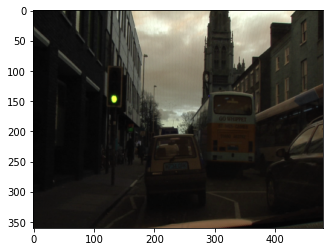

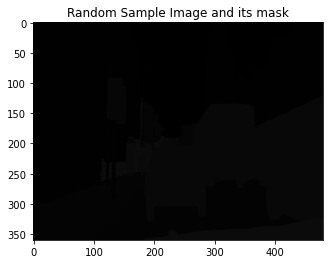

In [15]:
# visualize the data
img = cv2.imread('train/'+os.listdir(os.path.join('train'))[0])
plt.imshow(img, cmap='seismic', interpolation='bilinear')
plt.show()

msk = cv2.imread('trainannot/'+os.listdir(os.path.join('trainannot'))[0])
plt.imshow(msk, cmap='seismic')
plt.title('Random Sample Image and its mask')
plt.show()


In [16]:
len(os.listdir(os.path.join('test')))

233

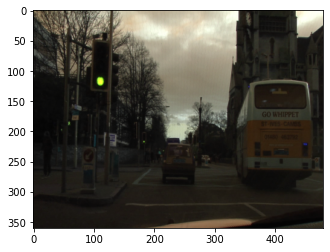

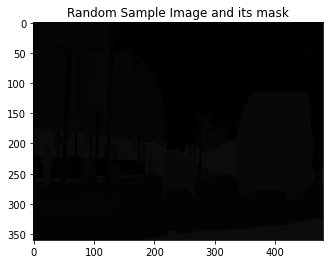

In [17]:
# visualize the data
img = cv2.imread('train/'+os.listdir(os.path.join('train'))[10])
plt.imshow(img, cmap='seismic', interpolation='bilinear')
plt.show()

msk = cv2.imread('trainannot/'+os.listdir(os.path.join('trainannot'))[10])
plt.imshow(msk, cmap='seismic')
plt.title('Random Sample Image and its mask')
plt.show()


In [0]:
X_train=[]
Y_train=[]
height=256
width=256

X_train=np.zeros((len(os.listdir(os.path.join('train'))),height,width,3),dtype='float32')
for i in range(len(os.listdir(os.path.join('train')))):
  img = cv2.imread('train/'+os.listdir(os.path.join('train'))[i])
  img=cv2.resize(img,(height,width),interpolation=cv2.INTER_AREA)
  img=np.array(img)
  X_train[i]=img/255
Y_train=np.zeros((len(os.listdir(os.path.join('trainannot'))),height,width,1),dtype='float32')
for i in range(len(os.listdir(os.path.join('trainannot')))):
  img=cv2.imread('trainannot/'+os.listdir(os.path.join('trainannot'))[i])
  img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  img=cv2.resize(img,(height,width),interpolation=cv2.INTER_AREA)
  img=np.array(img)
  img.shape=(height,width,1)
  Y_train[i]=img/255

In [0]:
X_test=[]
Y_test=[]
height=256
width=256

X_test=np.zeros((len(os.listdir(os.path.join('test'))),height,width,3),dtype='float32')
for i in range(len(os.listdir(os.path.join('test')))):
  img = cv2.imread('test/'+os.listdir(os.path.join('test'))[i])
  img=cv2.resize(img,(height,width),interpolation=cv2.INTER_AREA)
  img=np.array(img)
  X_test[i]=img/255
Y_test=np.zeros((len(os.listdir(os.path.join('testannot'))),height,width,1),dtype='float32')
for i in range(len(os.listdir(os.path.join('testannot')))):
  img=cv2.imread('testannot/'+os.listdir(os.path.join('testannot'))[i])
  img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  img=cv2.resize(img,(height,width),interpolation=cv2.INTER_AREA)
  img=np.array(img)
  img.shape=(height,width,1)
  Y_test[i]=img/255

In [0]:
X_val=[]
Y_val=[]
height=256
width=256

X_val=np.zeros((len(os.listdir(os.path.join('val'))),height,width,3),dtype='float32')
for i in range(len(os.listdir(os.path.join('val')))):
  img = cv2.imread('val/'+os.listdir(os.path.join('val'))[i])
  img=cv2.resize(img,(height,width),interpolation=cv2.INTER_AREA)
  img=np.array(img)
  X_val[i]=img/255
Y_val=np.zeros((len(os.listdir(os.path.join('valannot'))),height,width,1),dtype='float32')
for i in range(len(os.listdir(os.path.join('valannot')))):
  img=cv2.imread('valannot/'+os.listdir(os.path.join('valannot'))[i])
  img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  img=cv2.resize(img,(height,width),interpolation=cv2.INTER_AREA)
  img=np.array(img)
  img.shape=(height,width,1)
  Y_val[i]=img/255

In [0]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

In [0]:
def UNet():
    f = [16, 32, 64, 128, 256]
    inputs = Input((image_size, image_size, 3))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #128 -> 64
    c2, p2 = down_block(p1, f[1]) #64 -> 32
    c3, p3 = down_block(p2, f[2]) #32 -> 16
    c4, p4 = down_block(p3, f[3]) #16->8
    
    bn = bottleneck(p4, f[4])
    
    u1 = up_block(bn, c4, f[3]) #8 -> 16
    u2 = up_block(u1, c3, f[2]) #16 -> 32
    u3 = up_block(u2, c2, f[1]) #32 -> 64
    u4 = up_block(u3, c1, f[0]) #64 -> 128
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    model = keras.models.Model(inputs, outputs)
    return model

In [24]:
import keras
image_size=256
model = UNet()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 16) 2320        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 128, 128, 16) 0           conv2d_2[0][0]                   
____________________________________________________________________________________________

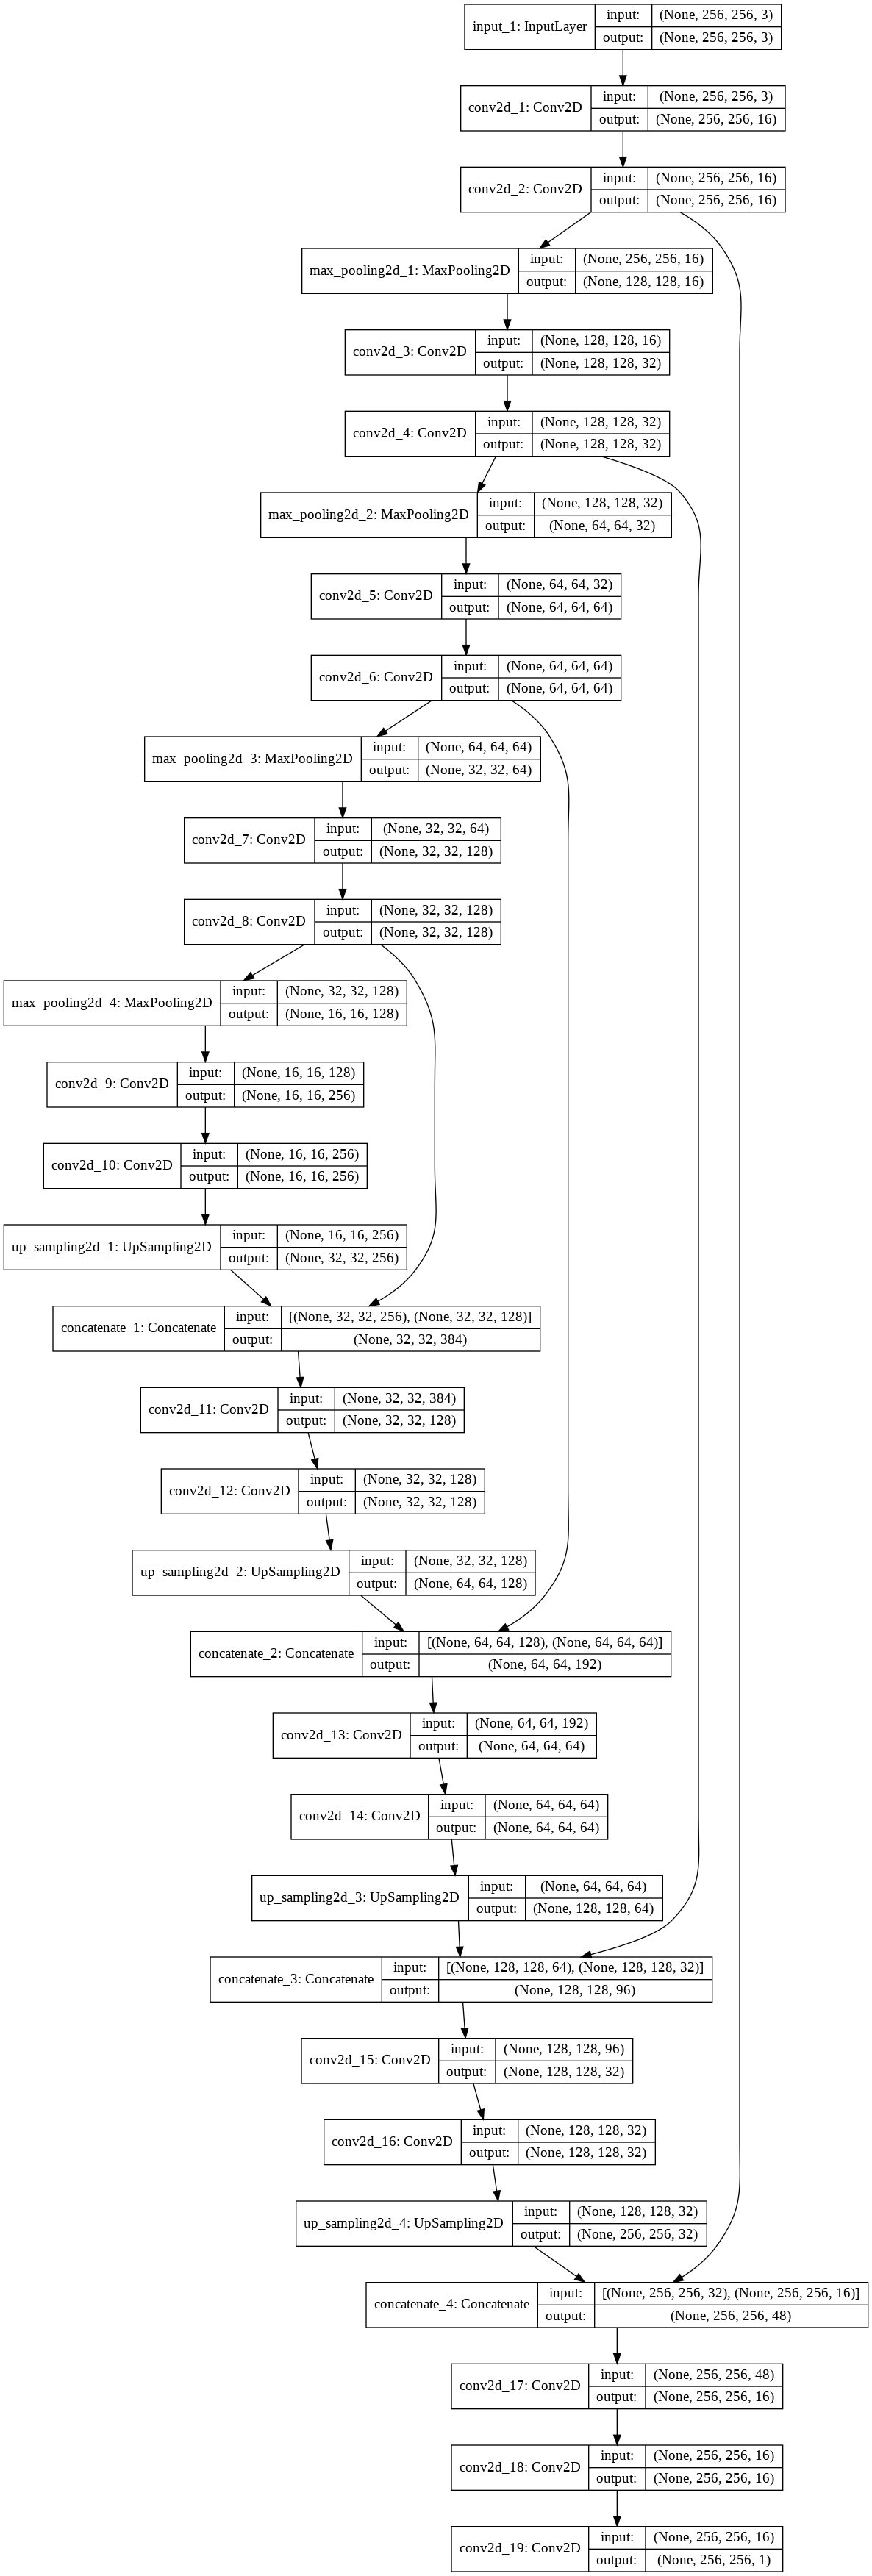

In [25]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [26]:

callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-camvid.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

history = model.fit(X_train, Y_train, epochs=5, batch_size=16, validation_data=(X_val, Y_val),callbacks=callbacks)

Train on 367 samples, validate on 101 samples
Epoch 1/5
367/367 [==============================] - 11s 29ms/step - loss: 0.1765 - acc: 0.1577 - val_loss: 0.0838 - val_acc: 0.0888

Epoch 00001: val_loss improved from inf to 0.08376, saving model to model-camvid.h5
Epoch 2/5
367/367 [==============================] - 2s 6ms/step - loss: 0.0679 - acc: 0.1578 - val_loss: 0.0676 - val_acc: 0.0888

Epoch 00002: val_loss improved from 0.08376 to 0.06764, saving model to model-camvid.h5
Epoch 3/5
367/367 [==============================] - 2s 6ms/step - loss: 0.0636 - acc: 0.1578 - val_loss: 0.0676 - val_acc: 0.0888

Epoch 00003: val_loss improved from 0.06764 to 0.06759, saving model to model-camvid.h5
Epoch 4/5
367/367 [==============================] - 2s 6ms/step - loss: 0.0633 - acc: 0.1578 - val_loss: 0.0668 - val_acc: 0.0888

Epoch 00004: val_loss improved from 0.06759 to 0.06681, saving model to model-camvid.h5
Epoch 5/5
367/367 [==============================] - 2s 6ms/step - loss: 0.0

:INPUT:


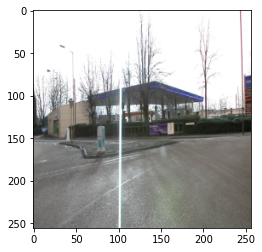

:ACTUAL:


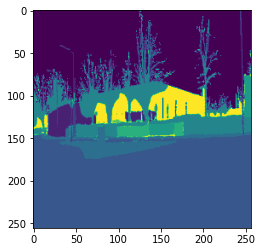

:PREDICTED:


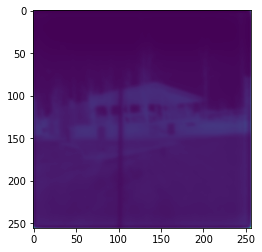

In [27]:
idex = 80

pred = model.predict(X_train[idex].reshape(1,height,width,3))

print(":INPUT:")
plt.imshow(X_train[idex])
plt.show()

print(":ACTUAL:")
plt.imshow(Y_train[idex].reshape(height, width))
plt.show()

print(":PREDICTED:")
plt.imshow(pred[0].reshape(height, width))
plt.show()

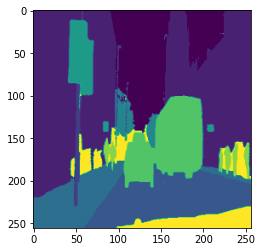

In [28]:
plt.imshow(Y_train[2].reshape(height, width))

In [29]:
history = model.fit(X_train, Y_train, epochs=25, batch_size=8, validation_data=(X_val, Y_val))

Train on 367 samples, validate on 101 samples
Epoch 1/25
367/367 [==============================] - 4s 10ms/step - loss: 0.0629 - acc: 0.1578 - val_loss: 0.0666 - val_acc: 0.0888
Epoch 2/25
367/367 [==============================] - 3s 7ms/step - loss: 0.0626 - acc: 0.1578 - val_loss: 0.0662 - val_acc: 0.0888
Epoch 3/25
367/367 [==============================] - 3s 7ms/step - loss: 0.0623 - acc: 0.1578 - val_loss: 0.0659 - val_acc: 0.0888
Epoch 4/25
367/367 [==============================] - 3s 7ms/step - loss: 0.0621 - acc: 0.1578 - val_loss: 0.0660 - val_acc: 0.0888
Epoch 5/25
367/367 [==============================] - 3s 7ms/step - loss: 0.0619 - acc: 0.1578 - val_loss: 0.0657 - val_acc: 0.0888
Epoch 6/25
367/367 [==============================] - 3s 7ms/step - loss: 0.0618 - acc: 0.1578 - val_loss: 0.0658 - val_acc: 0.0888
Epoch 7/25
367/367 [==============================] - 3s 7ms/step - loss: 0.0618 - acc: 0.1578 - val_loss: 0.0657 - val_acc: 0.0888
Epoch 8/25
367/367 [=========

:INPUT:


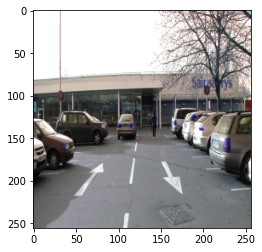

:ACTUAL:


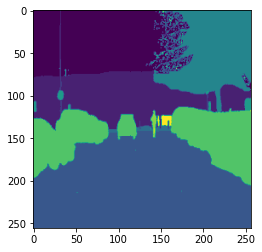

:PREDICTED:


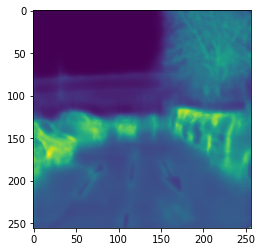

In [30]:
idex = 121

pred = model.predict(X_train[idex].reshape(1,height,width,3))
print(":INPUT:")
plt.imshow(X_train[idex])
plt.show()

print(":ACTUAL:")
plt.imshow(Y_train[idex].reshape(height, width))
plt.show()

print(":PREDICTED:")
plt.imshow(pred[0].reshape(height, width))
plt.show()

:INPUT:


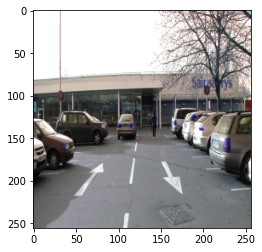

:ACTUAL:


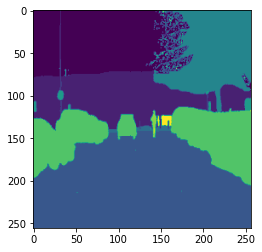

:PREDICTED:


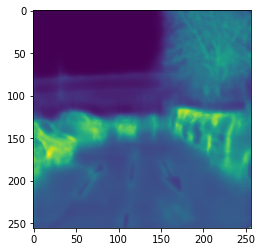

In [31]:
idex = 121

pred = model.predict(X_train[idex].reshape(1,height,width,3))
preds_val_t = (pred > 0.5).astype(np.uint8)
print(":INPUT:")
plt.imshow(X_train[idex])
plt.show()

print(":ACTUAL:")
plt.imshow(Y_train[idex].reshape(height, width))
plt.show()

print(":PREDICTED:")
plt.imshow(pred[0].reshape(height, width))
plt.show()

:INPUT:


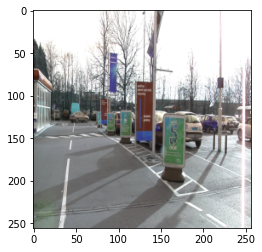

:ACTUAL:


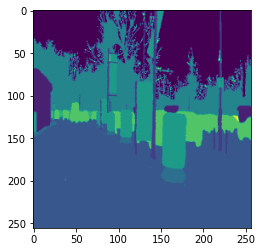

:PREDICTED:


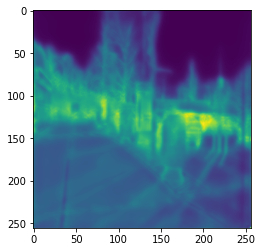

In [32]:
idex = 100

pred = model.predict(X_train[idex].reshape(1,height,width,3))
preds_val_t = (pred > 0.5).astype(np.uint8)
print(":INPUT:")
plt.imshow(X_train[idex])
plt.show()

print(":ACTUAL:")
plt.imshow(Y_train[idex].reshape(height, width))
plt.show()

print(":PREDICTED:")
plt.imshow(pred[0].reshape(height, width))
plt.show()